<a href="https://colab.research.google.com/github/yohei0408/no.2/blob/main/20240908_signate_50_beginner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torchmetrics==0.11.4 pytorch_lightning==2.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 43.1 MB/s eta 0:00:00


In [2]:
import pytorch_lightning as pl
import torchmetrics
from torchmetrics.functional import accuracy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

In [3]:
df = pd.read_csv('/content/train.csv')
df.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [4]:
df1 = pd.get_dummies(df, drop_first=True, dtype=int)
df1.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Gender_Male
0,59,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0,1
1,69,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1,1
2,65,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0,1
3,65,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1,1
4,22,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0,0


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          850 non-null    int64  
 1   T_Bil        850 non-null    float64
 2   D_Bil        850 non-null    float64
 3   ALP          850 non-null    float64
 4   ALT_GPT      850 non-null    float64
 5   AST_GOT      850 non-null    float64
 6   TP           850 non-null    float64
 7   Alb          850 non-null    float64
 8   AG_ratio     850 non-null    float64
 9   disease      850 non-null    int64  
 10  Gender_Male  850 non-null    int64  
dtypes: float64(8), int64(3)
memory usage: 73.2 KB


In [6]:
df1.describe()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Gender_Male
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,46.610588,1.607337,0.606737,272.211316,41.978476,61.018120,7.032290,3.517458,1.144570,0.444706,0.825882
std,16.453672,2.443585,1.569032,200.348515,145.927366,110.125390,0.840664,0.559942,0.227237,0.497226,0.379434
min,10.000000,0.585961,0.034861,163.261838,3.924518,11.283497,4.858679,2.180884,0.627133,0.000000,0.000000
25%,32.000000,0.781258,0.144889,213.991414,13.644658,21.239157,6.730612,3.139153,1.004466,0.000000,1.000000
50%,48.000000,0.835591,0.194085,220.092503,16.638001,27.056026,6.915580,3.621339,1.205016,0.000000,1.000000
75%,62.000000,1.196759,0.335447,229.455927,23.056081,56.461568,7.536151,3.712524,1.287880,1.000000,1.000000
max,78.000000,23.017027,17.692164,2108.483728,1423.186473,814.439397,8.739000,5.016970,1.821496,1.000000,1.000000


In [8]:
df1_corr = df1.corr()
df1_corr

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Gender_Male
Age,1.000000,-0.001248,-0.014136,-0.023907,-0.037906,-0.008589,-0.037754,-0.087120,-0.033220,0.024216,0.097987
T_Bil,-0.001248,1.000000,0.753227,0.148064,0.219784,0.248709,-0.060230,-0.162017,-0.206122,0.357653,0.114855
D_Bil,-0.014136,0.753227,1.000000,0.091924,0.184403,0.201485,0.017750,-0.089132,-0.121481,0.282316,0.092690
ALP,-0.023907,0.148064,0.091924,1.000000,-0.021187,0.019047,0.025728,-0.023041,-0.159614,0.211950,0.018019
ALT_GPT,-0.037906,0.219784,0.184403,-0.021187,1.000000,0.655518,-0.100572,-0.087652,0.005806,0.199239,0.079440
AST_GOT,-0.008589,0.248709,0.201485,0.019047,0.655518,1.000000,-0.071592,-0.086669,-0.022277,0.316456,0.098786
TP,-0.037754,-0.060230,0.017750,0.025728,-0.100572,-0.071592,1.000000,0.727319,0.270246,-0.073766,-0.019136
Alb,-0.087120,-0.162017,-0.089132,-0.023041,-0.087652,-0.086669,0.727319,1.000000,0.607400,-0.176602,-0.058460
AG_ratio,-0.033220,-0.206122,-0.121481,-0.159614,0.005806,-0.022277,0.270246,0.607400,1.000000,-0.307895,-0.011348
disease,0.024216,0.357653,0.282316,0.211950,0.199239,0.316456,-0.073766,-0.176602,-0.307895,1.000000,0.104987


In [9]:
df2 = df1.drop(['Gender_Male','TP','Age'], axis=1)
df2.head()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,Alb,AG_ratio,disease
0,0.786886,0.150498,220.178691,13.467617,21.729246,3.112276,1.006802,0
1,1.003987,0.195625,221.218413,51.033462,64.752323,3.051521,0.751346,1
2,0.657140,0.081287,320.770533,12.625011,30.613180,2.489167,0.774952,0
3,0.906822,0.214173,369.278160,34.347597,54.510085,3.613837,0.988155,1
4,1.734959,0.197706,222.782025,20.572891,170.010177,3.068697,1.026654,0


In [10]:
t1 = df1['disease']
x1 = df1.drop('disease', axis=1)
t1.head()

,disease
0,0
1,1
2,0
3,1
4,0


In [11]:
x1.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,Gender_Male
0,59,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,1
1,69,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,1
3,65,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [12]:
x1 = torch.tensor(x1.values, dtype=torch.float32)
t1 = torch.tensor(t1.values, dtype=torch.int64)
t1

tensor([0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,

In [13]:
dataset = torch.utils.data.TensorDataset(x1, t1)
n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.2)
n_test = len(dataset) - n_train - n_val

pl.seed_everything(0)
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

pl.seed_everything(0)

batch_size = 10

train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [14]:
df1['disease'].value_counts()

,count
disease,
0,472
1,378


In [15]:
class Net(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.bn = nn.BatchNorm1d(10)
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 2)


    def forward(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        return h


    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=2, top_k=1), on_step=True, on_epoch=True, prog_bar=True)
        return loss


    # 検証データに対する処理
    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=2, top_k=1), on_step=False, on_epoch=True)
        return loss


    # テストデータに対する処理
    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=2, top_k=1), on_step=False, on_epoch=True)
        return loss


    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.parameters(), lr=0.01)
        return optimizer

In [17]:
# GPU を含めた乱数のシードを固定
pl.seed_everything(0)

# 学習の実行
net = Net()
logger = CSVLogger(save_dir='logs', name='my_exp')
trainer = pl.Trainer(max_epochs=30, accelerator="gpu", deterministic=False, logger=logger)
trainer.fit(net, train_loader, val_loader)
# テストデータで検証
results = trainer.test(dataloaders=test_loader)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/my_exp/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type        | Params
-------------------------------------
0 | bn   | BatchNorm1d | 20    
1 | fc1  | Linear      | 55    
2 | fc2  | Linear      | 12    
-------------------------------------
87        Trainable 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/my_exp/version_0/checkpoints/epoch=29-step=1260.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/my_exp/version_0/checkpoints/epoch=29-step=1260.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8078431487083435     │
│         test_loss         │    0.46679750084877014    │
└───────────────────────────┴───────────────────────────┘

In [28]:
t = df2['disease']
x = df2.drop('disease', axis=1)
t.head()

,disease
0,0
1,1
2,0
3,1
4,0


In [19]:
x.head()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,Alb,AG_ratio
0,0.786886,0.150498,220.178691,13.467617,21.729246,3.112276,1.006802
1,1.003987,0.195625,221.218413,51.033462,64.752323,3.051521,0.751346
2,0.657140,0.081287,320.770533,12.625011,30.613180,2.489167,0.774952
3,0.906822,0.214173,369.278160,34.347597,54.510085,3.613837,0.988155
4,1.734959,0.197706,222.782025,20.572891,170.010177,3.068697,1.026654


In [74]:
t = df2['disease']
x = df2.drop('disease', axis=1)
x = torch.tensor(x.values, dtype=torch.float32)
t = torch.tensor(t.values, dtype=torch.int64)
dataset = torch.utils.data.TensorDataset(x, t)
n_train = int(len(dataset) * 0.5)
n_val = int(len(dataset) * 0.2)
n_test = len(dataset) - n_train - n_val

pl.seed_everything(0)
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

pl.seed_everything(0)

batch_size = 100

train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [92]:
class Net(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.bn = nn.BatchNorm1d(7)
        self.fc1 = nn.Linear(7, 2)
        self.fc2 = nn.Linear(2, 2)


    def forward(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        return h


    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=2, top_k=1), on_step=True, on_epoch=True, prog_bar=True)
        return loss


    # 検証データに対する処理
    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=2, top_k=1), on_step=False, on_epoch=True)
        return loss


    # テストデータに対する処理
    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=2, top_k=1), on_step=False, on_epoch=True)
        return loss


    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.parameters(), lr=0.01)
        return optimizer

In [93]:
# GPU を含めた乱数のシードを固定
pl.seed_everything(0)

# 学習の実行
net = Net()
logger = CSVLogger(save_dir='logs', name='my_exp')
trainer = pl.Trainer(max_epochs=30, accelerator="gpu", deterministic=False, logger=logger)
trainer.fit(net, train_loader, val_loader)
# テストデータで検証
results = trainer.test(dataloaders=test_loader)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type        | Params
-------------------------------------
0 | bn   | BatchNorm1d | 14    
1 | fc1  | Linear      | 16    
2 | fc2  | Linear      | 6     
-------------------------------------
36        Trainable params
0         Non-trainable params
36        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/my_exp/version_0/checkpoints/epoch=29-step=120-v6.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/my_exp/version_0/checkpoints/epoch=29-step=120-v6.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8627451062202454     │
│         test_loss         │    0.41796624660491943    │
└───────────────────────────┴───────────────────────────┘

In [94]:
log = pd.read_csv('logs/my_exp/version_0/metrics.csv')

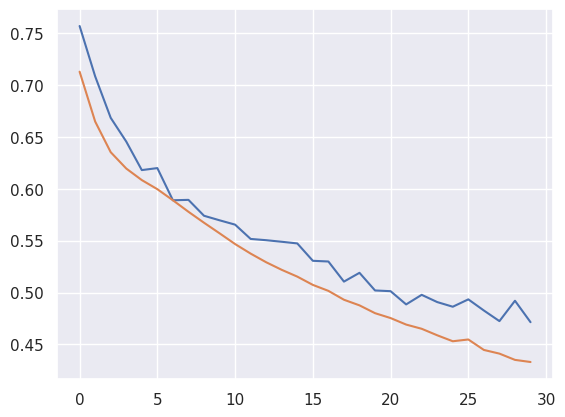

In [95]:
# loss
log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot();
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot();

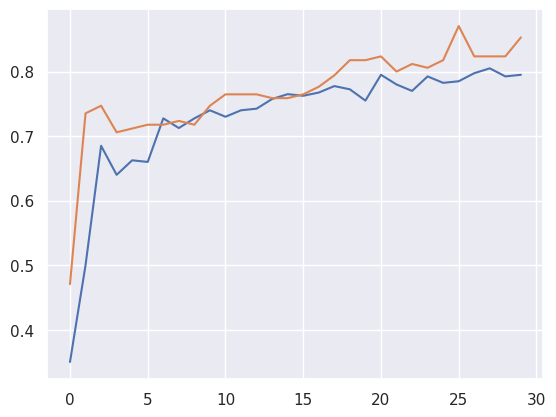

In [96]:
# accuracy
log[['train_acc_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_acc_epoch'].plot();
log[['val_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot();

In [99]:
# テストデータの読み込み
test_df = pd.read_csv('/content/test.csv')


test_df.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,25,Male,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,26,Female,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,64,Male,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579
3,65,Male,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070
4,34,Female,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078


In [103]:
test_df2 = test_df.drop(['Gender','TP','Age'], axis=1)
test_df2.head()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,Alb,AG_ratio
0,0.801797,0.186800,214.448679,15.260516,19.496649,3.600752,1.288006
1,0.834857,0.116426,234.136816,10.509159,16.733312,3.111043,1.030562
2,0.791830,0.197940,216.039909,14.578304,20.695866,3.627621,1.278579
3,0.834003,0.175741,200.901130,12.820356,20.102517,3.626758,1.275070
4,0.690296,0.135503,208.705835,20.279018,25.096685,4.170750,1.280078


In [105]:
# テストデータをtensorに変換
x_test = torch.tensor(test_df2.values, dtype=torch.float32)

In [106]:
# 予測
y = torch.argmax(net(x_test), dim=1)

In [108]:
import pandas as pd

# id 列を 0 から始まる連番で作成
id_list = range(len(y))  # y の長さに応じて id を生成

# データフレームを作成
df_submit = pd.DataFrame({
    'id': id_list,
    'class': y  # 予測した "肝疾患の有無 (0 or 1) もしくは0-1の確率値"
})
df_submit.head()

# CSV ファイルとして保存（ヘッダ無し）
#df.to_csv('submission.csv', index=False, header=False)




,id,class
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [110]:
df_submit['class'].value_counts()

,count
class,
0,241
1,109


In [111]:
# CSV ファイルとして保存（ヘッダ無し）
df_submit.to_csv('submit.csv', index=False, header=False)